# <center>Nuclear Energy Sentiment Analysis<center>


#### We scrape data from Google News and Twitter to compare the sentiment towards nuclear energy in Germany over the last two years.
#### Context: In Germany the nuclear phase-out was basically political consens until the war in Ukraine started in late February 2022. Since then an energy shortage discussion started because of the country's dependence of Russian gas. Hence the topic of nuclear energy came back to life last year, with some major political parties bringing even building new power plants back on the agenda. 
#### We try to analyze how that discussion is represented in news headlines and on Twitter and evaluate the sentiment towards the topic of nuclear energy.
#### **1.** About 1600 german news article headlines are evaluated with a pretrained BERT model ("german-news-sentiment-bert") from Huggingface which was trained on German news articles. The data is scraped from Google News from Jan 2021 until the end of   Jan of 2023
#### **2.** For our Twitter analysis we fine tune a BERT text classifier model ("german-sentiment-bert") from Huggingface on a rated Twitter dataset  from the Technical University of Berlin.
#### **3.** We analyse the sentiment of roughly 45 000 Twitter posts from Jan 2021 until Jan 2023
#### **4.** Interpretation of the results.

***

#### **Hypotheseis 1** : The topic of nuclear energy should be trending more often on Twitter since Feb 2022, and also the amount of news articles related to that matter should be have increased.

#### **Hypotheseis 2**: There should not only be an absoute increase of articles and Twitter posts concering nuclear energy but also an relative increase of favourable content.

***
#### Top:
1.  [Goolge News Headlines](#1)
2.  [Fine Tuning NLP model](#2)
3.  [Twitter Analysis](#3)
4.  [Interpretation](#4)
***



In [ ]:
# we import some standard libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## **1. Evaluate News Article Headlines**<a id="1"></a>

#### We Scrape German news articles about nuclear energy from the last two year from Google

In [ ]:
import datetime
from datetime import timedelta
from gnews import GNews

google_news = GNews()

article_list = []

start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2023, 1, 31)

for single_date in daterange(start_date, end_date):
   
   year = int(single_date.strftime("%Y"))
   month = int(single_date.strftime("%m"))
   day = int(single_date.strftime("%d"))
   
   start = datetime.date(year, month, day)
   end = start + timedelta(days = 1)


   google_news = GNews(language='de', country='Germany', start_date=start, end_date=end)
   article_list.append(google_news.get_news("Atomkraft"))

In [ ]:
articles = [i for j in article_list for i in j]
google_news = pd.DataFrame(articles)

In [ ]:
google_news['date'] = pd.to_datetime(google_news['published date'])
google_news['date']=google_news['date'].apply(lambda x: x.strftime('%Y-%m'))


## Filtering for key words in headlines

In [ ]:
# 2431 headlines conatain one of the key words

google_news = google_news.loc[google_news['title'].str.contains("Atom\w*|Kern\w*|Nuklear\w*", case = False)]
google_news.shape

(2431, 7)

In [ ]:
# text cleaning
# we exclude words that represent nuclear energy as they have a negative connotation and influence our sentiment analysis

import regex as re

def cleanNews(text):
    
    RE_ATOM = re.compile(r'Atom[-\w]*', re.IGNORECASE)
    RE_KERN = re.compile(r'Kern[-\w]*', re.IGNORECASE)
    RE_NUKLEAR = re.compile(r'Nuklear[-\w]*', re.IGNORECASE)
    text = re.sub(RE_ATOM, " ",text)
    text = re.sub(RE_KERN, " ",text)
    text = re.sub(RE_NUKLEAR, " ",text)
    text = re.sub('\n',' ',text)
    RE_LINK = re.compile(r"^https?://", re.IGNORECASE)
    RE_HASH = re.compile(r"(#\S+\ ){2,}", re.IGNORECASE)
    text = re.sub(RE_HASH, "",text)
    text = re.sub(RE_LINK,"", text)
    text = re.sub('#','',text) 
    text = re.sub('[^A-Za-z,ä,ü,ö,ß,Ä,Ü,Ö,.,;,?,!]++', ' ', text) 
    return text

google_news['cleaned_text'] = google_news['title'].apply(cleanNews)
 

### Pretrained BERT model for the evaluation

In [ ]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
    )

model_id = 'mdraw/german-news-sentiment-bert'


# load the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

# load the tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load the tokenizer and model into a sentiment analysis pipeline
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    
    )

In [ ]:
google_news['sentiment'] = google_news['cleaned_text'].apply(nlp)
google_news['sentiment']= google_news.sentiment.apply(lambda x: x[0]['label'])
google_news.drop_duplicates(subset=['cleaned_text'], keep='first', inplace=True, ignore_index = True)
google_news.head()

,title,description,published date,url,publisher,date,cleaned_text,sentiment,condition
0,Nuklearforschung: Staatsmedien: Iran hat Anrei...,Nuklearforschung: Staatsmedien: Iran hat Anrei...,"Mon, 04 Jan 2021 08:00:00 GMT",https://www.handelsblatt.com/politik/internati...,"{'href': 'https://www.handelsblatt.com', 'titl...",2021-01,Staatsmedien Iran hat Anreicherung von Uran a...,neutral,before
1,Beendet die Kernfusion den Klimanotstand? - Da...,Beendet die Kernfusion den Klimanotstand? Das...,"Sat, 09 Jan 2021 08:00:00 GMT",https://www.daswetter.com/nachrichten/wissensc...,"{'href': 'https://www.daswetter.com', 'title':...",2021-01,Beendet die den Klimanotstand? Daswetter.com,negative,before
2,Kernkraft: In Schweden wird die Atomkraft wied...,Kernkraft: In Schweden wird die Atomkraft wied...,"Tue, 12 Jan 2021 08:00:00 GMT",https://www.energie-und-management.de/nachrich...,{'href': 'https://www.energie-und-management.d...,2021-01,In Schweden wird die wieder salonfähig Energi...,neutral,before
3,Volkswagen: Streit mit Frankreich um Atom-U-Bo...,Volkswagen: Streit mit Frankreich um Atom-U-Bo...,"Tue, 12 Jan 2021 08:00:00 GMT",https://www.sueddeutsche.de/wirtschaft/volkswa...,"{'href': 'https://www.sueddeutsche.de', 'title...",2021-01,Volkswagen Streit mit Frankreich um Süddeutsch...,neutral,before
4,Mau-Club hilft Musikern aus Norddeutschland du...,Mau-Club hilft Musikern aus Norddeutschland du...,"Tue, 12 Jan 2021 08:00:00 GMT",https://www.ln-online.de/der-norden/wie-der-ro...,"{'href': 'https://www.ln-online.de', 'title': ...",2021-01,Mau Club hilft Musi aus Norddeutschland durch ...,neutral,before


## Plots

In [ ]:
war_date = '2022-02'

google_news['condition'] = google_news.date.apply(lambda x: 'before' if x < war_date else 'since')


Text(0.5, 0.98, 'News headlines: relatitve sentiment comparison before and since the war')

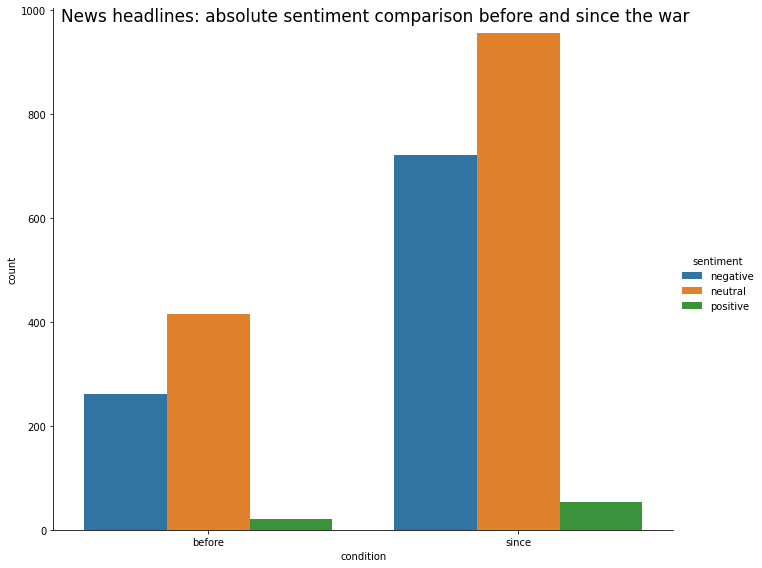

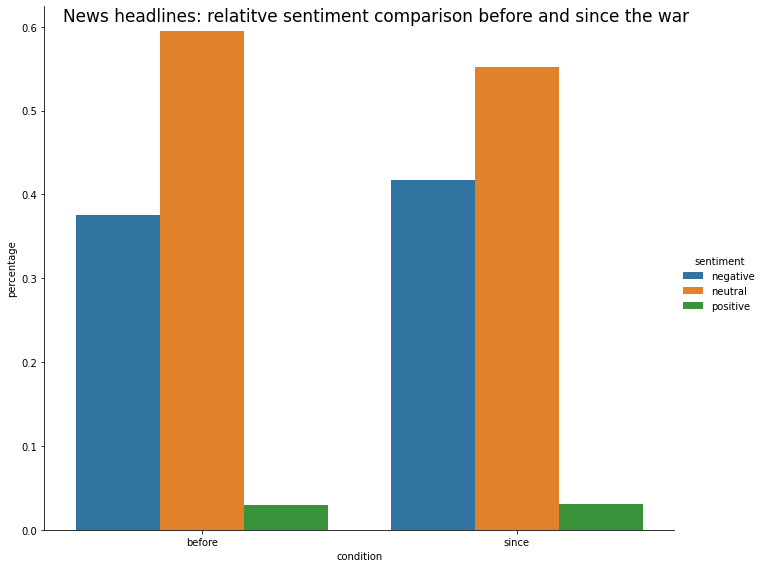

In [ ]:
message_count = google_news.groupby(['condition', 'sentiment'])["title"].count().reset_index(name="count")
               

total = message_count.groupby(['condition']).sum()['count']

message_count.loc[message_count['condition'] == 'before', 'percentage'] = message_count['count']/total[0]
message_count.loc[message_count['condition'] == 'since', 'percentage'] = message_count['count']/total[1]             

g_abs = sns.catplot(x='condition', y='count', hue='sentiment', data= message_count, kind='bar', height=8, aspect=1.2)
g_abs.set_axis_labels("condition", "count")
g_abs.fig.suptitle('News headlines: absolute sentiment comparison before and since the war',  fontsize=17)


g_rel = sns.catplot(x='condition', y='percentage', hue='sentiment', data= message_count, kind='bar', height=8, aspect=1.2)
g_rel.set_axis_labels("condition", "percentage")
g_rel.fig.suptitle('News headlines: relatitve sentiment comparison before and since the war',fontsize=17)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

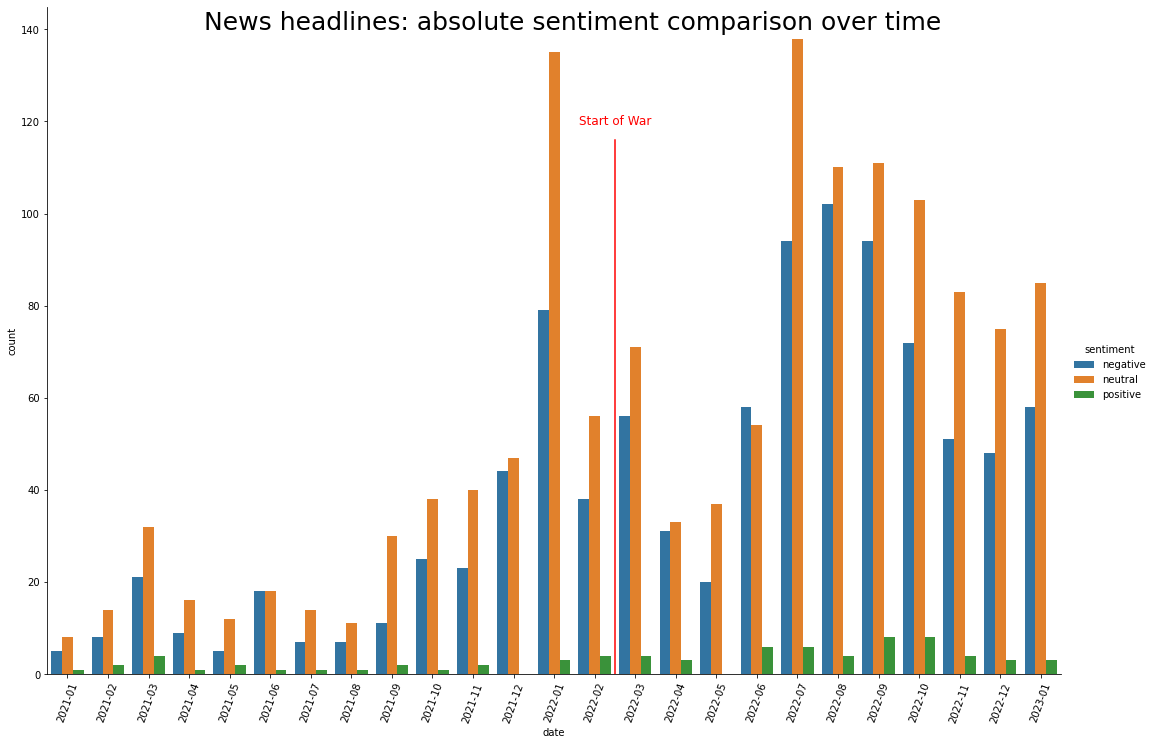

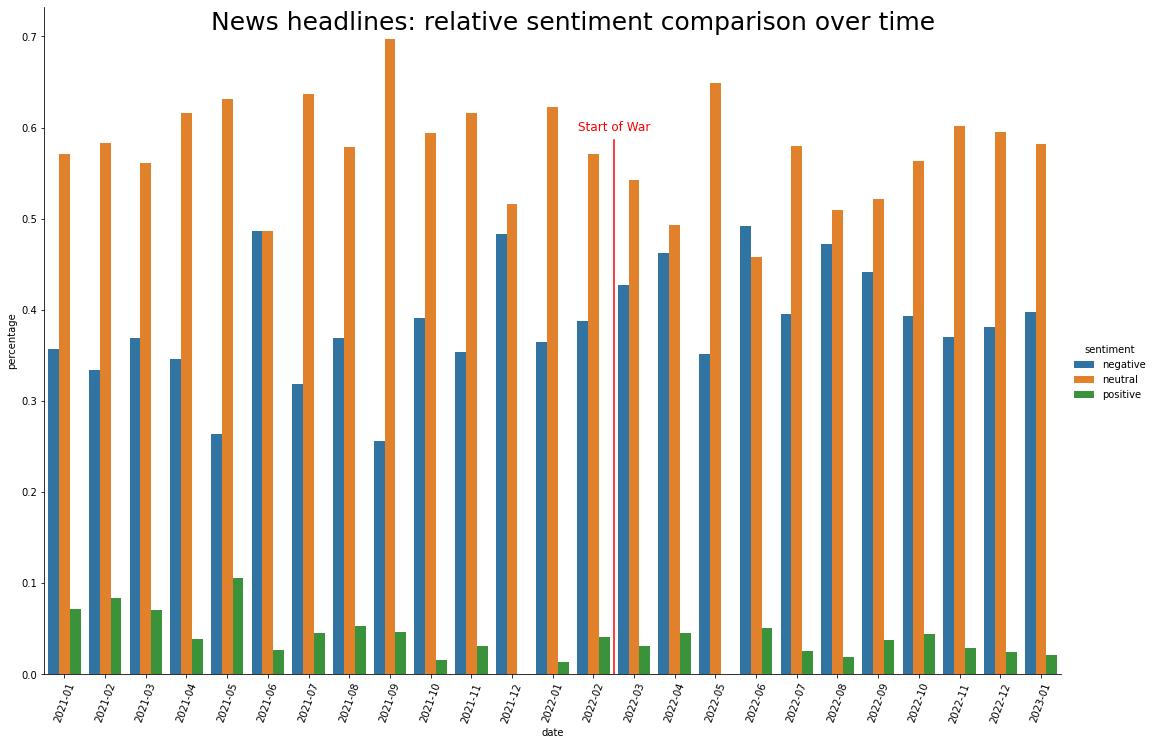

In [ ]:
message_count = google_news.groupby(['date', 'sentiment'])["title"].count().reset_index(name="count")

temp_df = pd.DataFrame(message_count.groupby(['date']).sum()['count'])
temp_df = temp_df.reset_index()

message_count['total'] = message_count.merge(temp_df, left_on='date', right_on='date')['count_y']

message_count['percentage'] = message_count['count'] / message_count['total']
    

g_abs = sns.catplot(x='date', y='count', hue='sentiment', data= message_count, kind='bar', height=10, aspect=1.5)
g_abs.set_axis_labels("date", "count")
g_abs.fig.suptitle('News headlines: absolute sentiment comparison over time', fontsize=25)
plt.axvline(13.5,0,0.8, color='r')
plt.text(13.5,120,'Start of War', fontsize=12, color = 'red', horizontalalignment='center',
     verticalalignment='center')
plt.xticks(rotation=70)


g_rel = sns.catplot(x='date', y='percentage', hue='sentiment', data= message_count, kind='bar', height=10, aspect=1.5)
g_rel.set_axis_labels("date", "percentage")
g_rel.fig.suptitle('News headlines: relative sentiment comparison over time', fontsize=25)
plt.axvline(13.5, 0,0.8, color='r')
plt.text(13.5,0.6,'Start of War', fontsize=12, color = 'red', horizontalalignment='center',
     verticalalignment='center')
plt.xticks(rotation=70)

## **2. Fine Tune BERT Model on Twitter dataset**<a id="2"></a>
To fine tune the Transformer a German Twitter dataset from the Technical University of Berlin with a 100% interrater reliablity of about 1600 tweets is used

http://dainas.aot.tu-berlin.de/~andreas@dai/sentiment/

In [ ]:
file = '/content/drive/MyDrive/Phyton/Project/Sentiment/SentimentDataset/de_sentiment_agree2.tsv'
df = pd.read_csv(file, sep = "\t")

In [ ]:
df = df.loc[df.sentiment != 'na']
df.sentiment.value_counts()

neutral     1073
positive     350
negative     237
Name: sentiment, dtype: int64

In [ ]:

label_dict = {'negative':1, 'positive':0, 'neutral':2}
df['label'] = df['sentiment'].apply(lambda x: label_dict[x])

df.rename(columns = {'tweet': 'text'}, inplace = True)
df = df[['label', 'text']]
df.head()

,label,text
0,2,New Post: Samsung bestätigt Produktionsbeginn...
1,2,Base Lutea oder Samsung Galaxy Ace? Ich hab d...
2,2,Jeden Tag ein neues Aktionsangebot - das Kenne...
3,2,Hör dir Katy Perry von Firework an! Ich habe d...
4,0,Dank @user geht es mir jetzt schon besser *_* ...


In [ ]:
import regex as re

def cleanTweets(text):
    
    
    text = re.sub('@[A-Za-z0-9_]+', '', text) 
    text = re.sub('RT[\s]+','',text)
    text = re.sub('\n',' ',text)
    RE_LINK = re.compile(r"^https?://", re.IGNORECASE)
    RE_HASH = re.compile(r"(#\S+\ ){2,}", re.IGNORECASE)
    text = re.sub(RE_HASH, "",text)
    text = re.sub(RE_LINK,"", text)
    text = re.sub('#','',text) 
    text = re.sub('[^A-Za-z,ä,ü,ö,ß,Ä,Ü,Ö,.,;,?,!]++', ' ', text) 
    return text

df['text'] = df['text'].apply(cleanTweets)

df.head()

,label,text
0,2,New Post Samsung bestätigt Produktionsbeginn b...
1,2,Base Lutea oder Samsung Galaxy Ace? Ich hab di...
2,2,Jeden Tag ein neues Aktionsangebot das Kenner ...
3,2,Hör dir Katy Perry von Firework an! Ich habe d...
4,0,Dank geht es mir jetzt schon besser lt;


In [ ]:
df.to_csv("/content/drive/MyDrive/Phyton/Project/Sentiment/Twitter_train_dataset.csv", index = False)

In [ ]:
from datasets import load_dataset

file = "/content/drive/MyDrive/Phyton/Project/Sentiment/Twitter_train_dataset.csv"

dataset = load_dataset("csv", data_files = file)
dataset = dataset.shuffle()
dataset["train"][50]

In [ ]:
split = 0.7
total_range = dataset["train"].shape[0]
train_range = int(total_range*split)
train_range

train_dataset = dataset["train"].select(range(0,train_range))

test_dataset = dataset["train"].select(range(train_range,total_range))

In [ ]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

model = TFAutoModelForSequenceClassification.from_pretrained("oliverguhr/german-sentiment-bert")


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")

def tokenize_dataset(data):
    
    return tokenizer(data["text"], padding=True, truncation= True)

train_dataset = train_dataset.map(tokenize_dataset)
test_dataset = test_dataset.map(tokenize_dataset)


In [ ]:

tf_train_dataset = model.prepare_tf_dataset(train_dataset, batch_size=16, shuffle=False, tokenizer=tokenizer)
tf_test_dataset = model.prepare_tf_dataset(test_dataset, batch_size=16, shuffle=False, tokenizer=tokenizer)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
model.compile(optimizer=Adam(3e-6), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109081344 
                                                                 
 dropout_265 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,083,651
Trainable params: 109,083,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# for fine tuning only a couple of epochs with a small learning rate is recommended

model_history = model.fit(tf_train_dataset, validation_data= tf_test_dataset, epochs = 5, verbose=1)

Epoch 1/5
73/73 [==============================] - 24s 104ms/step - loss: 6.3757 - accuracy: 0.5361 - val_loss: 5.8669 - val_accuracy: 0.5683
Epoch 2/5
73/73 [==============================] - 5s 62ms/step - loss: 4.8730 - accuracy: 0.6205 - val_loss: 4.8478 - val_accuracy: 0.6345
Epoch 3/5
73/73 [==============================] - 5s 64ms/step - loss: 4.4702 - accuracy: 0.6454 - val_loss: 4.4429 - val_accuracy: 0.6546
Epoch 4/5
73/73 [==============================] - 5s 63ms/step - loss: 4.2260 - accuracy: 0.6687 - val_loss: 4.2609 - val_accuracy: 0.6546
Epoch 5/5
73/73 [==============================] - 5s 64ms/step - loss: 3.9782 - accuracy: 0.6773 - val_loss: 4.1053 - val_accuracy: 0.6627


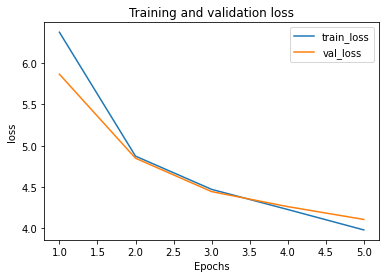

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(model_history, 'loss')

In [ ]:
from transformers import pipeline

nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer)

In [ ]:
texts = [
    "Mit keinem guten Ergebniss","Das ist gar nicht mal so gut",
    "Total awesome!","nicht so schlecht wie erwartet",
    "Er saß auf einer Bank.","Sie fährt ein grünes Auto."]
       
result = nlp(texts)
result

[{'label': 'negative', 'score': 0.9977014660835266},
 {'label': 'negative', 'score': 0.9990742206573486},
 {'label': 'positive', 'score': 0.991233766078949},
 {'label': 'positive', 'score': 0.9809808731079102},
 {'label': 'neutral', 'score': 0.9993686079978943},
 {'label': 'neutral', 'score': 0.9987461566925049}]

## **3. Evaluate Twitter posts**<a id="3"></a>

#### We scrape post from the last two years containing our key words

In [ ]:
import snscrape.modules.twitter as sntwitter
import itertools

def scraper(list, interval):
    
    first_element = True
    for i in list:
        tag = '#'+ i + " " + interval
        print(tag)
        
        data = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
            tag).get_items(),30000))
        
        if first_element == True:
            df = data
            first_element = False
            
        else:
            df = pd.concat([data, df], axis = 0)
            
            
    return df

interval_1 =  'since:2021-01-01 until:2022-02-24'
interval_2 =  'since:2022-02-25 until:2023-01-31'
list = ['Kernenergie', 'Atomkraft']
data_1 = scraper(list, interval_1)
data_2 = scraper(list, interval_2)
df_1 = data_1[['date', 'id', 'renderedContent']]
df_2 = data_2[['date', 'id', 'renderedContent']]
df = df = pd.concat([df_1, df_2], axis = 0)

In [ ]:
df.drop_duplicates(subset=['renderedContent'], keep='first', inplace=True, ignore_index = True)
df.shape

(61066, 3)

In [ ]:
# text cleaning 

import regex as re

def cleanTweets(text):
    
    RE_ATOM = re.compile(r'Atom\w*', re.IGNORECASE)
    RE_KERN = re.compile(r'Kern\w*', re.IGNORECASE)
    RE_NUKLEAR = re.compile(r'Nuklear\w*', re.IGNORECASE)
    text = re.sub(RE_ATOM, "",text)
    text = re.sub(RE_KERN, "",text)
    text = re.sub(RE_NUKLEAR, "",text)
    text = re.sub('@[A-Za-z0-9_]+', '', text) 
    text = re.sub('[^A-Za-z,ä,ü,ö,ß,Ä,Ü,Ö,.,;,?,!]+', ' ', text) 
    text = re.sub(',', ' ', text)  
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text)
    text = re.sub('https', '', text)  
    text = re.sub('\n',' ',text)
    RE_LINK = re.compile(r"http\S+", re.IGNORECASE)
    RE_HASH = re.compile(r"(#\S+\ ){2,}", re.IGNORECASE)
    text = re.sub(RE_HASH, "",text)
    text = re.sub(RE_LINK,"", text)
    text = re.sub('#','',text) 
    return text

df['cleanedTweets'] = df['renderedContent'].apply(cleanTweets)
 
df.head() 

,date,id,renderedContent,cleanedTweets
0,2022-02-23 23:41:27+00:00,1496631320918863874,"@PiratMainBrain @MarvinWendland1 Das heißt, di...",Das heißt die Piraten wenden such wieder der...
1,2022-02-23 21:54:38+00:00,1496604438915653641,@tagesthemen @tagesschau Kein Wort zu #Atomkra...,Kein Wort zu und Laufzeitverlängerung Wir sin...
2,2022-02-23 21:12:18+00:00,1496593784477528080,Es war ein großer Fehler #Atomkraft lahmzulege...,Es war ein großer Fehler lahmzulegen und Deuts...
3,2022-02-23 20:06:51+00:00,1496577315584761865,RETTET DIE EU-TAXONOMIE: KEIN ÖKO-LABEL FÜR AT...,RETTET DIE EU TAXONOMIE KEIN ÖKO LABEL FÜR UND...
4,2022-02-23 20:00:44+00:00,1496575775713210370,"Vor wenigen Wochen, Monaten sagte ich, dass wi...",Vor wenigen Wochen Monaten sagte ich dass wi...


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

In [ ]:
# cut off at 4 characters for each tweet

from nltk.tokenize import word_tokenize

df['cleaned'] = df['cleanedTweets'].apply(lambda x: True if len(word_tokenize(x)) >= 4 else False)
df = df.loc[df['cleaned']!=False]
df.head()

,date,id,renderedContent,cleanedTweets,cleaned
0,2022-02-23 23:41:27+00:00,1496631320918863874,"@PiratMainBrain @MarvinWendland1 Das heißt, di...",Das heißt die Piraten wenden such wieder der...,True
1,2022-02-23 21:54:38+00:00,1496604438915653641,@tagesthemen @tagesschau Kein Wort zu #Atomkra...,Kein Wort zu und Laufzeitverlängerung Wir sin...,True
2,2022-02-23 21:12:18+00:00,1496593784477528080,Es war ein großer Fehler #Atomkraft lahmzulege...,Es war ein großer Fehler lahmzulegen und Deuts...,True
3,2022-02-23 20:06:51+00:00,1496577315584761865,RETTET DIE EU-TAXONOMIE: KEIN ÖKO-LABEL FÜR AT...,RETTET DIE EU TAXONOMIE KEIN ÖKO LABEL FÜR UND...,True
4,2022-02-23 20:00:44+00:00,1496575775713210370,"Vor wenigen Wochen, Monaten sagte ich, dass wi...",Vor wenigen Wochen Monaten sagte ich dass wi...,True


In [ ]:
df.shape

(59751, 5)

In [ ]:
!pip install langdetect

In [ ]:
# only tweets in German are used for evaluation

from langdetect import detect

df['de'] = df['cleanedTweets'].apply(lambda x: True if detect(x) == 'de' else False)

In [ ]:
df = df[df.de == True]
df.reset_index(drop = True, inplace = True)

In [ ]:
# 43907 tweets will be evaluated

df.shape

(43907, 6)

### The fine tuned BERT model is used here

In [ ]:
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer)


In [ ]:
sentiment_1 = df['cleanedTweets'][0:10000].apply(nlp)

In [ ]:
sentiment_2 = df['cleanedTweets'][10000:20000].apply(nlp)

In [ ]:
sentiment_3 = df['cleanedTweets'][20000:30000].apply(nlp)

In [ ]:
sentiment_4 = df['cleanedTweets'][30000::].apply(nlp)

In [ ]:
sentiment = pd.concat([sentiment_1, sentiment_2, sentiment_3, sentiment_4])
df['sentiment'] = sentiment


In [ ]:
df['sentiment']= df.sentiment.apply(lambda x: x[0]['label'])

In [ ]:
df['date']=df['date'].apply(lambda x: x.strftime('%Y-%m'))

In [ ]:
df.drop(['test'], axis = 1, inplace = True)

In [ ]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
df[df['sentiment'] =='positive'].head(10)

,date,id,renderedContent,cleanedTweets,cleaned,de,sentiment
104,2022-02,1495409839627026444,@DrAndreasS Das sehe ich anders. #Atomkraft is...,Das sehe ich anders. ist nicht nachhaltig und...,True,True,positive
163,2022-02,1494212593153675267,@Wnschmstr Genau weil ja #Atomkraft #AberOhneS...,Genau weil ja AberOhneStaat so super funktion...,True,True,positive
179,2022-02,1493578756325265408,#Atomkraft ist #sicher und wir haben alles imm...,ist sicher und wir haben alles immer unter Ko...,True,True,positive
229,2022-02,1492794569058045952,"Gas ist super für die Umwelt, Atomkraft sicher...",Gas ist super für die Umwelt sicher vielleich...,True,True,positive
320,2022-02,1491853511897894912,"Danke, @ausgestrahlt, für die Einblicke in die...",Danke für die Einblicke in die französische...,True,True,positive
409,2022-02,1491159796124467208,#Atomkraft &amp; #Gentechnik sind voll toll fü...,amp; Gentechnik sind voll toll für das Klima....,True,True,positive
516,2022-02,1490393241421758467,"#Atomkraft ist nachhaltig! Etwa 200.000 Jahre,...",ist nachhaltig! Etwa . Jahre strahlt der Abf...,True,True,positive
524,2022-02,1490346627328090120,#atomkraft ist besser und Umweltschonender als...,ist besser und Umweltschonender als Windenerg...,True,True,positive
695,2022-02,1489249022367784967,#Atomkraft nachhaltig machen? Dann ist meine t...,nachhaltig machen? Dann ist meine tägliche Pa...,True,True,positive
830,2022-02,1489156808245710850,#Atomkraft ist für jeden Bürger bezahlbar! 💸 #...,ist für jeden Bürger bezahlbar! Taxonomie Lanz,True,True,positive


## Plots

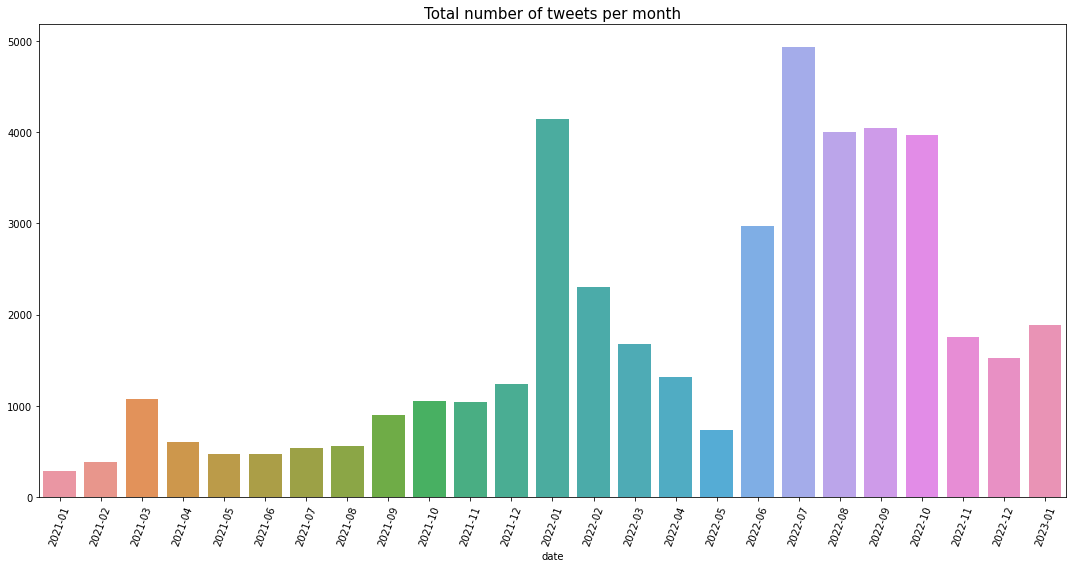

In [ ]:


message_count = df['sentiment'].groupby(df['date']).count()

plt.figure(figsize=(15, 8))
sns.barplot(x = message_count.index, y = message_count.values)
plt.xticks(rotation=70)
plt.title('Total number of tweets per month', fontsize = 15)
plt.tight_layout()

In [ ]:


war_date = '2022-02'

df['condition'] = df.date.apply(lambda x: 'before' if x < war_date else 'since')


Text(0.5, 0.98, 'Twitter: relatitve sentiment comparison before and since the war')

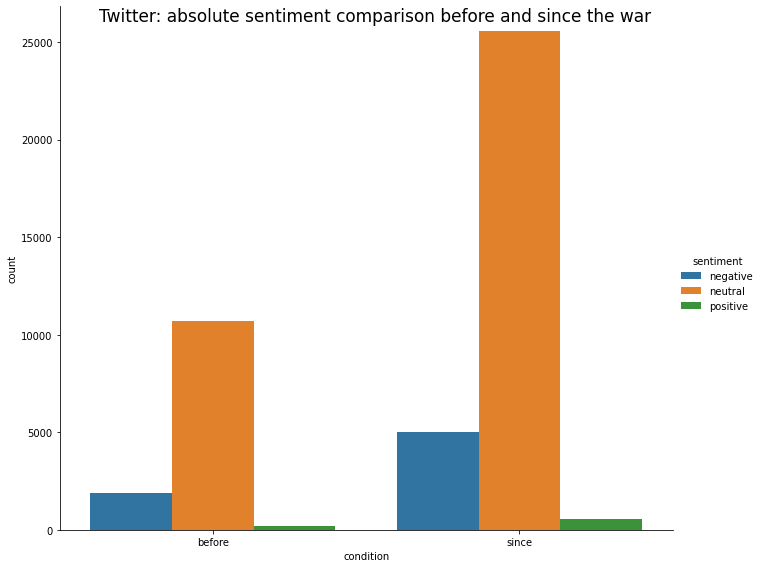

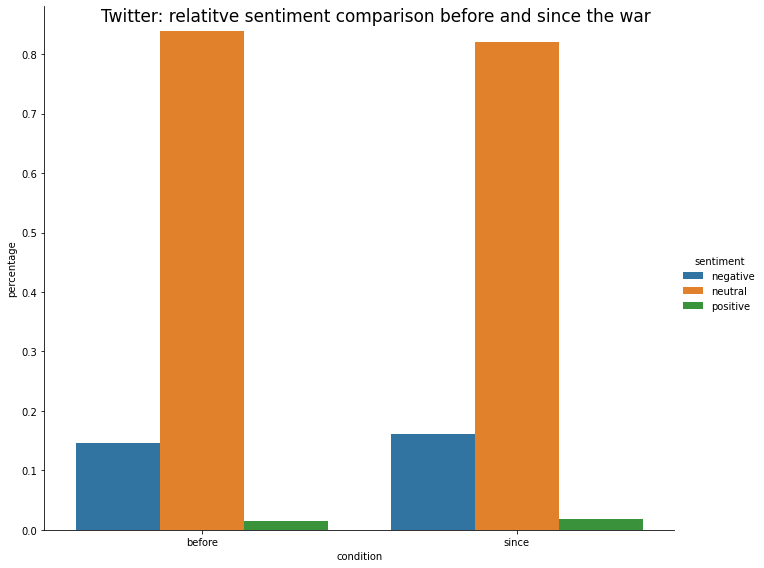

In [ ]:
message_count = df.groupby(['condition', 'sentiment'])["cleanedTweets"].count().reset_index(name="count")
               

total = message_count.groupby(['condition']).sum()['count']

message_count.loc[message_count['condition'] == 'before', 'percentage'] = message_count['count']/total[0]
message_count.loc[message_count['condition'] == 'since', 'percentage'] = message_count['count']/total[1]             

g_abs = sns.catplot(x='condition', y='count', hue='sentiment', data= message_count, kind='bar', height=8, aspect=1.2)
g_abs.set_axis_labels("condition", "count")
g_abs.fig.suptitle('Twitter: absolute sentiment comparison before and since the war',  fontsize=17)


g_rel = sns.catplot(x='condition', y='percentage', hue='sentiment', data= message_count, kind='bar', height=8, aspect=1.2)
g_rel.set_axis_labels("condition", "percentage")
g_rel.fig.suptitle('Twitter: relatitve sentiment comparison before and since the war',fontsize=17)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

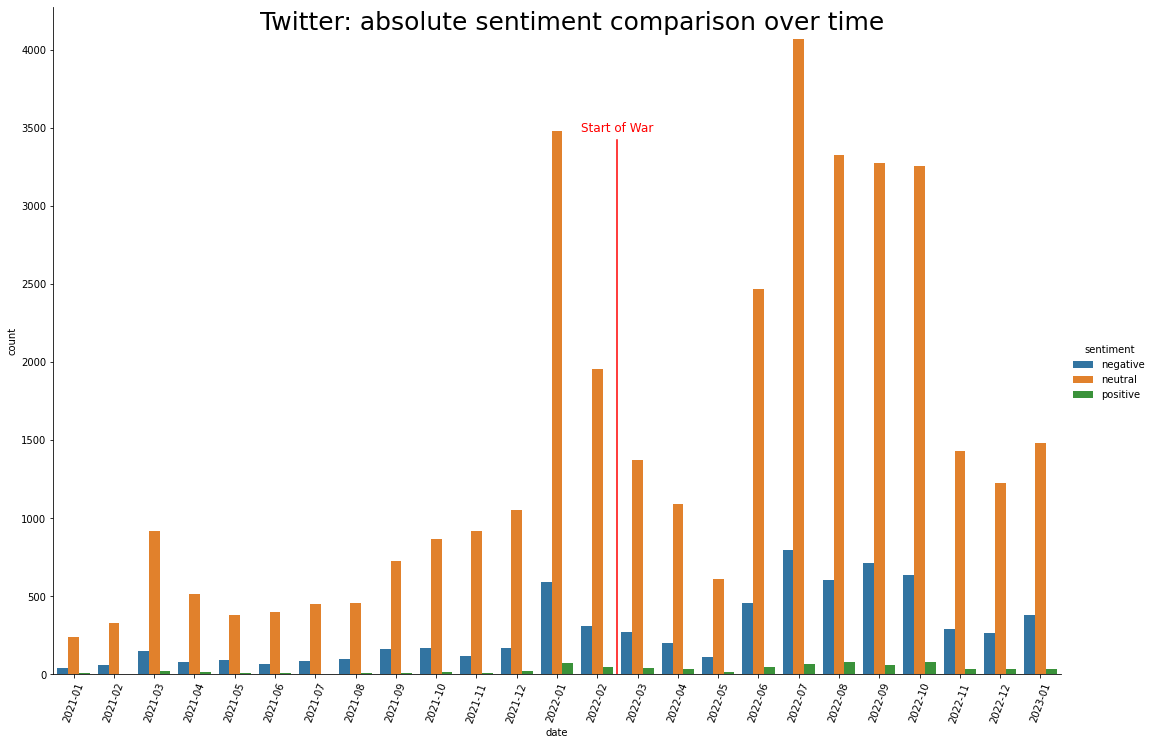

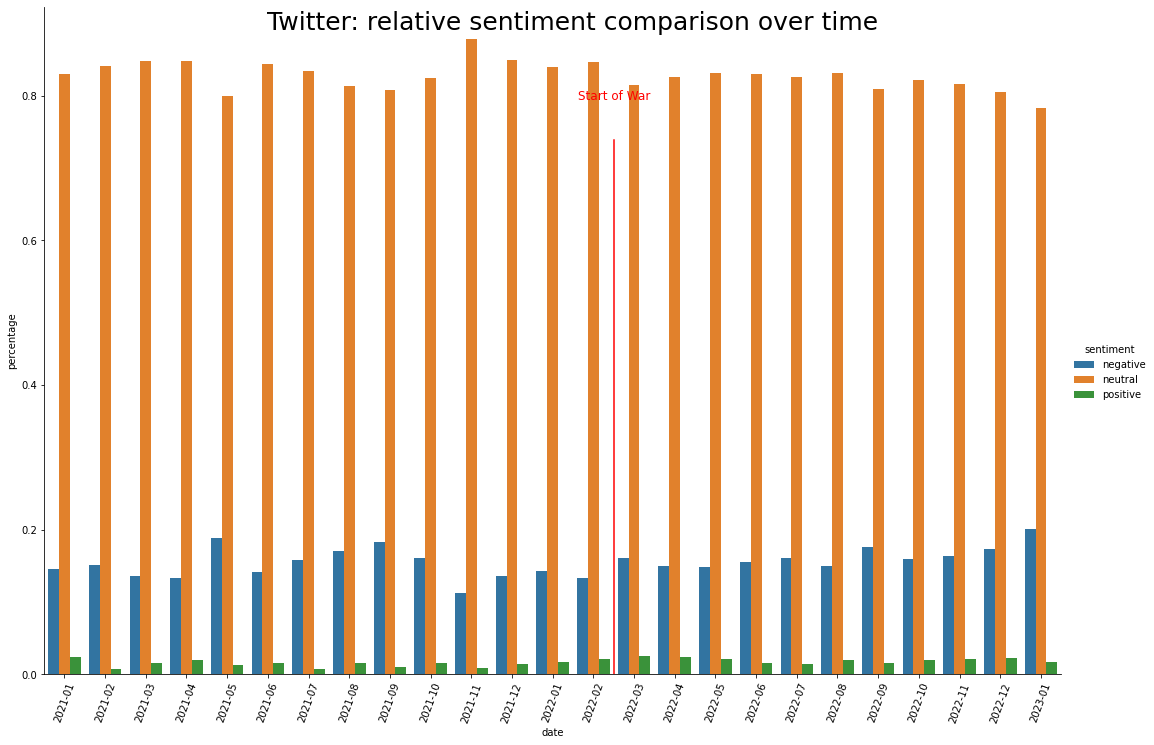

In [ ]:
message_count = df.groupby(['date', 'sentiment'])["cleanedTweets"].count().reset_index(name="count")

temp_df = pd.DataFrame(message_count.groupby(['date']).sum()['count'])
temp_df = temp_df.reset_index()


message_count['total'] = message_count.merge(temp_df, left_on='date', right_on='date')['count_y']

message_count['percentage'] = message_count['count'] / message_count['total']
    

g_abs = sns.catplot(x='date', y='count', hue='sentiment', data= message_count, kind='bar', height=10, aspect=1.5)
g_abs.set_axis_labels("date", "count")
g_abs.fig.suptitle('Twitter: absolute sentiment comparison over time', fontsize=25)
plt.axvline(13.5,0,0.8, color='r')
plt.text(13.5,3500,'Start of War', fontsize=12, color = 'red', horizontalalignment='center',
     verticalalignment='center')
plt.xticks(rotation=70)


g_rel = sns.catplot(x='date', y='percentage', hue='sentiment', data= message_count, kind='bar', height=10, aspect=1.5)
g_rel.set_axis_labels("date", "percentage")
g_rel.fig.suptitle('Twitter: relative sentiment comparison over time', fontsize=25)
plt.axvline(13.5, 0,0.8, color='r')
plt.text(13.5,0.8,'Start of War', fontsize=12, color = 'red', horizontalalignment='center',
     verticalalignment='center')
plt.xticks(rotation=70)

# **4. Interpretation**<a id="4"></a>

Surveys suggest that the sentiment towards nuclear energy in Germany became more favourble in general, but not among the younger population(14-49 years).
That would explain why the absolute positive sentiment on Twitter changed over the last two years but the relative positive sentiment didn't, as the before mentioned age group is the most active group on Twitter. 